In [3]:
from typing import List

import datasets
import evaluate

import json
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchinfo import summary

from tqdm.notebook import tqdm

In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Util functions

In [7]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [8]:
def compute_clm_loss(logits, labels):
    # Classical Language modeling task (nope)
    # Next token prediction task in causual setup
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1), ignore_index=-100)
    return loss

In [9]:
def compute_cosine_mse_loss(input_logits, output_logits, padding_mask):

    losses = []

    batch_size = padding_mask.shape[0]
    for batch_idx in range(batch_size):
        preds = input_logits[batch_idx, :][~padding_mask[batch_idx, :]]
        targets = output_logits[batch_idx, :][~padding_mask[batch_idx, :]]
        # print(preds.shape, targets.shape)

        loss = (1 - F.cosine_similarity(preds, targets, -1)).mean() + F.mse_loss(preds, targets)
        losses.append(loss)

    return torch.stack(losses).contiguous().mean()

In [10]:
def compute_shifted_cosine_mse_loss(input_logits, output_logits, padding_mask):

    rolled_input_mask = torch.roll(padding_mask, -1)
    shift_input = input_logits[:, :-1, :][~rolled_input_mask[:, :-1]].contiguous()
    shift_output = output_logits[:, 1:, :][~padding_mask[:, 1:]].contiguous()

    cos_loss = (1 - F.cosine_similarity(shift_input, shift_output, -1)).mean()
    mse_loss = F.mse_loss(shift_input, shift_output)

    return cos_loss + mse_loss

In [11]:
def compute_shifted_mse_loss(input_logits, output_logits, padding_mask):

    rolled_input_mask = torch.roll(padding_mask, -1)
    shift_input = input_logits[:, :-1, :][~rolled_input_mask[:, :-1]].contiguous()
    shift_output = output_logits[:, 1:, :][~padding_mask[:, 1:]].contiguous()

    mse_loss = F.mse_loss(shift_input, shift_output)

    return mse_loss

In [12]:
def compute_shifted_cross_l2_loss(input_logits, output_logits, padding_mask):
    losses = []

    batch_size = padding_mask.shape[0]
    for batch_idx in range(batch_size):

        preds = input_logits[batch_idx, :][~padding_mask[batch_idx, :]]
        targets = output_logits[batch_idx, :][~padding_mask[batch_idx, :]]

        orig_distances = torch.cdist(targets[1:], targets[1:]).detach()
        pred_distances = torch.cdist(preds[:-1], preds[:-1])

        idx = torch.triu_indices(*orig_distances.shape)
        loss = F.mse_loss(pred_distances[idx[0], idx[1]].view(-1), orig_distances[idx[0], idx[1]].view(-1))
        losses.append(loss)

    return torch.stack(losses).contiguous().mean()

#### Losses Playground

In [13]:
example_output = torch.rand([5, 8, 100], dtype=torch.float)
example_input = example_output.clone()
example_input[:, :-1] = example_output[:, 1:]
# compute_shifted_mse_loss(example_input, example_output, torch.zeros(5, 8).bool())

In [14]:
F.mse_loss(example_input[0][:-1], example_output[0][1:])

tensor(0.)

In [15]:
F.mse_loss(torch.cdist(example_output[0][1:], example_output[0][1:]).view(-1),
           torch.cdist(example_input[0][:-1], example_input[0][:-1]).view(-1))

tensor(0.)

In [16]:
torch.cdist(example_input[0][:-1], example_input[0][:-1])

tensor([[0.0000, 4.3862, 4.6061, 4.6068, 4.4111, 3.9176, 4.2555],
        [4.3862, 0.0000, 3.6091, 4.4636, 4.3510, 4.0947, 4.1751],
        [4.6061, 3.6091, 0.0000, 4.4537, 4.0674, 4.1071, 3.9881],
        [4.6068, 4.4636, 4.4537, 0.0000, 4.2209, 4.4106, 3.9097],
        [4.4111, 4.3510, 4.0674, 4.2209, 0.0000, 4.3559, 3.9257],
        [3.9176, 4.0947, 4.1071, 4.4106, 4.3559, 0.0000, 4.0253],
        [4.2555, 4.1751, 3.9881, 3.9097, 3.9257, 4.0253, 0.0000]])

In [17]:
torch.cdist(example_output[0][1:], example_output[0][1:])

tensor([[0.0000, 4.3862, 4.6061, 4.6068, 4.4111, 3.9176, 4.2555],
        [4.3862, 0.0000, 3.6091, 4.4636, 4.3510, 4.0947, 4.1751],
        [4.6061, 3.6091, 0.0000, 4.4537, 4.0674, 4.1071, 3.9881],
        [4.6068, 4.4636, 4.4537, 0.0000, 4.2209, 4.4106, 3.9097],
        [4.4111, 4.3510, 4.0674, 4.2209, 0.0000, 4.3559, 3.9257],
        [3.9176, 4.0947, 4.1071, 4.4106, 4.3559, 0.0000, 4.0253],
        [4.2555, 4.1751, 3.9881, 3.9097, 3.9257, 4.0253, 0.0000]])

In [18]:
torch.cdist(example_input[0][:-1], example_output[0][1:])

tensor([[0.0000, 4.3862, 4.6061, 4.6068, 4.4111, 3.9176, 4.2555],
        [4.3862, 0.0000, 3.6091, 4.4636, 4.3510, 4.0947, 4.1751],
        [4.6061, 3.6091, 0.0000, 4.4537, 4.0674, 4.1071, 3.9881],
        [4.6068, 4.4636, 4.4537, 0.0000, 4.2209, 4.4106, 3.9097],
        [4.4111, 4.3510, 4.0674, 4.2209, 0.0000, 4.3559, 3.9257],
        [3.9176, 4.0947, 4.1071, 4.4106, 4.3559, 0.0000, 4.0253],
        [4.2555, 4.1751, 3.9881, 3.9097, 3.9257, 4.0253, 0.0000]])

## Using allenai/soda dataset
This dataset contains dialogs, speakers labels, each dialog is a separate list of lines

In [19]:
soda_dataset = datasets.load_dataset('allenai/soda')
soda_dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /home/hivaze/.cache/huggingface/datasets/allenai___parquet/allenai--soda-354e990899ae2f4a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['head', 'relation', 'tail', 'literal', 'narrative', 'dialogue', 'speakers', 'PersonX', 'PersonY', 'PersonZ', 'original_index', 'split', 'head_answer', 'pmi_head_answer', 'relation_tail_answer', 'pmi_relation_tail_answer'],
        num_rows: 1191582
    })
    test: Dataset({
        features: ['head', 'relation', 'tail', 'literal', 'narrative', 'dialogue', 'speakers', 'PersonX', 'PersonY', 'PersonZ', 'original_index', 'split', 'head_answer', 'pmi_head_answer', 'relation_tail_answer', 'pmi_relation_tail_answer'],
        num_rows: 148968
    })
    validation: Dataset({
        features: ['head', 'relation', 'tail', 'literal', 'narrative', 'dialogue', 'speakers', 'PersonX', 'PersonY', 'PersonZ', 'original_index', 'split', 'head_answer', 'pmi_head_answer', 'relation_tail_answer', 'pmi_relation_tail_answer'],
        num_rows: 146346
    })
})

In [20]:
soda_dataset = soda_dataset.remove_columns([col for col in soda_dataset['train'].column_names if col not in ['dialogue', 'speakers']])
soda_dataset

DatasetDict({
    train: Dataset({
        features: ['dialogue', 'speakers'],
        num_rows: 1191582
    })
    test: Dataset({
        features: ['dialogue', 'speakers'],
        num_rows: 148968
    })
    validation: Dataset({
        features: ['dialogue', 'speakers'],
        num_rows: 146346
    })
})

In [21]:
def encode_interlocutors(row):
    first_speaker = row['speakers'][0]
    other_speaker = list(set(row['speakers']) - {first_speaker})[0]
    mapping = {
        first_speaker: 2,
        other_speaker: 3
    }
    fixed_speakers = list(map(lambda name: mapping.get(name, 2), row['speakers']))
    return {
        'speakers': fixed_speakers
    }

In [22]:
# {'ek': 34, 'mf3': 54}.get(1, 10)

In [23]:
soda_dataset = soda_dataset.map(encode_interlocutors, num_proc=11)
soda_dataset

Map (num_proc=11):   0%|          | 0/1191582 [00:00<?, ? examples/s]

Map (num_proc=11):   0%|          | 0/148968 [00:00<?, ? examples/s]

Map (num_proc=11):   0%|          | 0/146346 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['dialogue', 'speakers'],
        num_rows: 1191582
    })
    test: Dataset({
        features: ['dialogue', 'speakers'],
        num_rows: 148968
    })
    validation: Dataset({
        features: ['dialogue', 'speakers'],
        num_rows: 146346
    })
})

In [24]:
soda_dataset = soda_dataset.rename_columns({'dialogue': 'dialog', 'speakers': 'interlocutors'})
soda_dataset

DatasetDict({
    train: Dataset({
        features: ['dialog', 'interlocutors'],
        num_rows: 1191582
    })
    test: Dataset({
        features: ['dialog', 'interlocutors'],
        num_rows: 148968
    })
    validation: Dataset({
        features: ['dialog', 'interlocutors'],
        num_rows: 146346
    })
})

In [25]:
soda_dataset = soda_dataset.filter(lambda row: len(row['dialog']) == len(row['interlocutors']) and len(row['dialog']) > 1)
soda_dataset

Filter:   0%|          | 0/1191582 [00:00<?, ? examples/s]

Filter:   0%|          | 0/148968 [00:00<?, ? examples/s]

Filter:   0%|          | 0/146346 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['dialog', 'interlocutors'],
        num_rows: 1186423
    })
    test: Dataset({
        features: ['dialog', 'interlocutors'],
        num_rows: 148294
    })
    validation: Dataset({
        features: ['dialog', 'interlocutors'],
        num_rows: 145660
    })
})

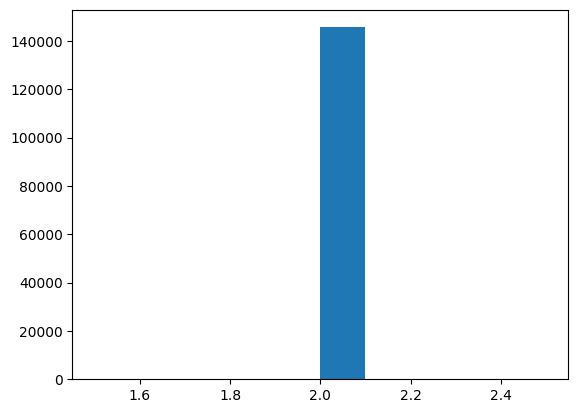

In [26]:
speakers_counts = [len(set(x)) for x in soda_dataset['validation']['interlocutors']]
plt.hist(speakers_counts)
plt.show()

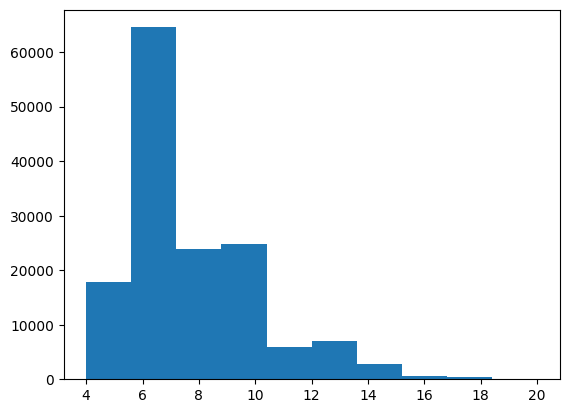

In [27]:
dialogs_lengths = [len(x) for x in soda_dataset['test']['dialog']]
plt.hist(dialogs_lengths)
plt.show()

## Phrase encoder model

In [28]:
# phrase_model = 'roberta-base'
# phrase_model = 'microsoft/deberta-v3-base'
# phrase_model = 'sentence-transformers/all-MiniLM-L12-v2'
# phrase_model = 'sentence-transformers/bert-base-nli-mean-tokens'
# phrase_model = 'intfloat/e5-base'
# phrase_model = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
phrase_model = 'sentence-transformers/paraphrase-mpnet-base-v2'
# phrase_model = 'sentence-transformers/sentence-t5-base'
# tokenizer = AutoTokenizer.from_pretrained(phrase_model)
# model = AutoModel.from_pretrained(phrase_model).to(device)
# model
sent_transformer = SentenceTransformer(model_name_or_path=phrase_model, device=device).eval().half()
sent_transformer

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [29]:
sent_transformer.max_seq_length = 256
sent_transformer

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [30]:
test_phrases = ['Some day i will go to school',
                'To make maximum progress on addressing these pressing problems',
                'I will nether go to school',
                'I like to visit school',
                'The day will come when i will go to school']

phrases_encodings = sent_transformer.encode(test_phrases, convert_to_tensor=True, normalize_embeddings=False)
phrases_encodings.shape

torch.Size([5, 768])

In [31]:
cosine_similarity(phrases_encodings.cpu(), phrases_encodings.cpu())

array([[1.0000001 , 0.07119123, 0.84428996, 0.64069384, 0.92123437],
       [0.07119123, 1.        , 0.05582385, 0.01420632, 0.13659608],
       [0.84428996, 0.05582385, 1.        , 0.5661354 , 0.7673865 ],
       [0.64069384, 0.01420632, 0.5661354 , 1.        , 0.574977  ],
       [0.92123437, 0.13659608, 0.7673865 , 0.574977  , 1.0000002 ]],
      dtype=float32)

## Dialog encoder model

Концептуально тут нужно:
- модель-кодировщик фраз (замоороженная) -> готовые эмбединги текста
- эмбединги участников диалога
- эмбединги позиции текста в диалоге
- кастомный токенизер c BOS и EOS
- causual lm crossentropy loss
- causual маска атеншена
- финальный классификатор в условный словарь

In [32]:
class DialogEmbeddings(nn.Module):
    def __init__(self, encoder_hidden_dim: int,
                 max_interlocutors_count: int,
                 max_dialogue_length: int,
                 dropout_p: float):
        super(DialogEmbeddings, self).__init__()

        self.padding_idx = 0  # special index for padding (must be in tokenizer)

        self.position_embeddings = nn.Embedding(max_dialogue_length + 1,  # padding
                                                encoder_hidden_dim, padding_idx=self.padding_idx)
        self.interlocutors_embeddings = nn.Embedding(max_interlocutors_count + 2,  # padding, eos, bos
                                                     encoder_hidden_dim, padding_idx=self.padding_idx)
        self.norm = nn.LayerNorm(encoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, interlocutors_ids: torch.LongTensor, position_ids: torch.LongTensor = None):
        if position_ids is None:
            position_ids = self.create_position_ids_from_input_ids(interlocutors_ids)

        interlocutors_embeds = self.interlocutors_embeddings(interlocutors_ids)
        position_embeds = self.position_embeddings(position_ids)

        embeddings = interlocutors_embeds + position_embeds
        embeddings = self.norm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

    def create_position_ids_from_input_ids(self, input_ids):
        """
        Replace non-padding symbols with their position numbers. Position numbers begin at padding_idx+1. Padding symbols
        are ignored. This is modified from fairseq's `utils.make_positions`. :param torch.Tensor x: :return torch.Tensor:
        """
        # The series of casts and type-conversions here are carefully balanced to both work with ONNX export and XLA.
        mask = input_ids.ne(self.padding_idx).int()
        incremental_indices = torch.cumsum(mask, dim=1).type_as(mask) * mask
        return incremental_indices.long() + self.padding_idx

In [33]:
class DialogMLP(nn.Module):
    def __init__(self,
                 encoder_hidden_dim: int,
                 dim_feedforward_mult: int = 3,
                 dropout_p: float = 0.1):
        super(DialogMLP, self).__init__()

        self.inner_proj = nn.Linear(encoder_hidden_dim, dim_feedforward_mult * encoder_hidden_dim)
        self.norm = nn.LayerNorm(dim_feedforward_mult * encoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.out_proj = nn.Linear(dim_feedforward_mult * encoder_hidden_dim, encoder_hidden_dim)
        # self.norm2 = nn.LayerNorm(encoder_hidden_dim)

    def forward(self, inp: torch.FloatTensor):
        x = F.gelu(self.inner_proj(inp))
        x = self.norm(self.dropout(x))
        x = self.out_proj(x)
        x = x + inp
        return x

In [34]:
class DialogTransformer(nn.Module):
    def __init__(self, encoder_hidden_dim: int,
                 max_dialogue_length: int,
                 max_interlocutors_count: int,
                 decoder_n_layers: int = 2,
                 decoder_n_head: int = 4,
                 dim_feedforward_mult: int = 3,
                 dropout_p: float = 0.1):
        super(DialogTransformer, self).__init__()

        # self.bos_vector = nn.Parameter(torch.randn([encoder_hidden_dim]), requires_grad=True)
        self.eos_vector = nn.Parameter(torch.randn([encoder_hidden_dim]), requires_grad=True)

        self.input_norm = nn.LayerNorm(encoder_hidden_dim)
        self.input_projection = nn.Linear(encoder_hidden_dim, encoder_hidden_dim)
        # self.input_projection = DialogMLP(encoder_hidden_dim, dim_feedforward_mult, dropout_p)
        self.dialogue_embeddings = DialogEmbeddings(encoder_hidden_dim, max_interlocutors_count,
                                                    max_dialogue_length, dropout_p)

        decoder_ff_inner_dim = encoder_hidden_dim * dim_feedforward_mult
        layer = nn.TransformerEncoderLayer(d_model=encoder_hidden_dim,
                                           nhead=decoder_n_head,
                                           dim_feedforward=decoder_ff_inner_dim,
                                           activation=F.gelu,  # using gelu instead of default relu
                                           dropout=dropout_p,
                                           batch_first=True)  # using encoder layers due to not a seq2seq setup
        self.model = nn.TransformerEncoder(layer, decoder_n_layers)

        # self.lstm_model = nn.LSTM(input_size=encoder_hidden_dim,
        #                           hidden_size=decoder_ff_inner_dim,
        #                           num_layers=decoder_n_layers,
        #                           bidirectional=False,
        #                           dropout=dropout_p,
        #                           batch_first=True)

        # self.logits_projector = DialogOutput(encoder_hidden_dim, dim_feedforward_mult, dropout_p=dropout_p)
        self.logits_projector = nn.Linear(in_features=encoder_hidden_dim, out_features=encoder_hidden_dim, bias=True)

        self.interlocutors_projector = nn.Linear(in_features=encoder_hidden_dim, out_features=max_interlocutors_count+1, bias=True)

    def forward(self, encodings: torch.FloatTensor,
                interlocutors_ids: torch.LongTensor,
                position_ids: torch.LongTensor = None,
                attention_mask: torch.BoolTensor = None,
                return_loss = True):
        """
        :param encodings: Pooled hiddens from sentence-transformer in shape [bs, lines_count, hidden_dim]
        :param labels: Labels for dialog lines
        :param interlocutors_ids: shape [bs, seq_len], interlocutors for each line (from one)
        :param position_ids: shape [bs, seq_len], position of line in dialogue (from one)
        :param attention_mask: shape [bs, seq_len], attention mask for padding where 1 is disabled and 0 is enabled
        """

        batch_size = encodings.shape[0]

        representation = torch.cat([
            # self.bos_vector.repeat([batch_size, 1, 1]),
            encodings,
            self.eos_vector.repeat([batch_size, 1, 1])
        ], dim=1)  # insert bos and eos vector

        x = self.input_norm(representation)
        x = self.input_projection(x)
        x = x + self.dialogue_embeddings(interlocutors_ids=interlocutors_ids, position_ids=position_ids)

        if attention_mask is None:
            attention_mask = torch.zeros([batch_size, x.shape[1]]).bool().to(x.device)

        causal_mask = torch.triu(torch.ones(x.shape[1], x.shape[1]), diagonal=1).bool().to(x.device)  # only attend to past (not necessary, but logical...)
        x = self.model.forward(src=x,
                               mask=causal_mask,
                               src_key_padding_mask=attention_mask)

        # x, (ht, ct) = self.lstm_model(x)

        predicted_logits = self.logits_projector(x)
        predicted_interlocutors = self.interlocutors_projector(x)

        if return_loss:
            copied_interlocutors = interlocutors_ids.clone() - 1
            copied_interlocutors[copied_interlocutors < 0] = -100

            interlocutors_loss = compute_clm_loss(predicted_interlocutors, copied_interlocutors)
            logits_loss = compute_shifted_mse_loss(predicted_logits, representation, padding_mask=attention_mask)

            total_loss = logits_loss + interlocutors_loss

            return total_loss, interlocutors_loss, predicted_logits, predicted_interlocutors

        return predicted_logits, predicted_interlocutors

In [35]:
torch.triu(torch.ones(10, 10), diagonal=1).bool()

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False]])

In [36]:
dialo_transformer = DialogTransformer(encoder_hidden_dim=768,
                                      max_dialogue_length=50,
                                      max_interlocutors_count=2,
                                      decoder_n_layers=4,
                                      decoder_n_head=6,
                                      dim_feedforward_mult=4,
                                      dropout_p=0.15
                                      ).to(sent_transformer.device).eval()
dialo_transformer

DialogTransformer(
  (input_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (input_projection): Linear(in_features=768, out_features=768, bias=True)
  (dialogue_embeddings): DialogEmbeddings(
    (position_embeddings): Embedding(51, 768, padding_idx=0)
    (interlocutors_embeddings): Embedding(4, 768, padding_idx=0)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (model): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,),

In [37]:
summary(dialo_transformer)

Layer (type:depth-idx)                                            Param #
DialogTransformer                                                 768
├─LayerNorm: 1-1                                                  1,536
├─Linear: 1-2                                                     590,592
├─DialogEmbeddings: 1-3                                           --
│    └─Embedding: 2-1                                             39,168
│    └─Embedding: 2-2                                             3,072
│    └─LayerNorm: 2-3                                             1,536
│    └─Dropout: 2-4                                               --
├─TransformerEncoder: 1-4                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─TransformerEncoderLayer: 3-1                          7,087,872
│    │    └─TransformerEncoderLayer: 3-2                          7,087,872
│    │    └─TransformerEncoderLayer: 3-3                         

## Dialog Tokenizer

In [38]:
class DialogTokenizer:
    """
    Accepts dicts with keys: 'dialog' - required, 'interlocutors' and 'labels'
    Must return dict with 'encoder_hidden', 'interlocutors_ids' and 'labels'
    """

    def __init__(self, lines_encoder: SentenceTransformer,
                 all_interlocutors: list = None):

        self.lines_encoder = lines_encoder
        for p in self.lines_encoder[0].parameters():
            p.requires_grad = False

        self.padding_idx = 0
        # self.bos_idx = 1
        self.eos_idx = 1

        if all_interlocutors:
            all_interlocutors = set(all_interlocutors)
            self.id2interlocutors = dict(zip(range(2, len(all_interlocutors) + 2), all_interlocutors))
            self.interlocutor2id = {v: k for k, v in self.id2interlocutors.items()}

    def encode(self, dialog: List[str],
               interlocutors: List[int] = None,
               lines_batch_size: int = 50,
               unsqueeze: bool = True,
               return_loss: bool = True,
               device: str = None,
               **kwargs):

        encodings = self.lines_encoder.encode(sentences=dialog,
                                              batch_size=lines_batch_size,
                                              normalize_embeddings=False,  # better not to normalize
                                              show_progress_bar=False,
                                              convert_to_tensor=True)
        # encodings = encodings.cpu()
        # encodings.requires_grad = False

        if interlocutors is None:
            interlocutors = [(i % 2) + 2 for i in range(len(dialog))]
        elif hasattr(self, 'interlocutor2id'):
            interlocutors = list(map(self.interlocutor2id.get, interlocutors))

        # print(interlocutors)
        interlocutors = interlocutors + [self.eos_idx]

        save_device = device if device is not None else encodings.device

        result = {
            'encodings': encodings.unsqueeze(0).to(save_device) if unsqueeze else encodings.to(save_device),
            'interlocutors_ids': torch.LongTensor([interlocutors] if unsqueeze else interlocutors).to(save_device),
            'return_loss': return_loss
        }

        return result

    def encode_batch(self, dialog: List[List[str]],
                     interlocutors: List[List[int]] = None,
                     lines_batch_size: int = 50,
                     return_loss: bool = True,
                     **kwargs):

        if interlocutors is None:
            interlocutors = [None] * len(dialog)
        unsqueeze = [False] * len(dialog)

        assert len(dialog) == len(interlocutors)

        zipped = zip(dialog, interlocutors, [lines_batch_size] * len(dialog), unsqueeze)
        encoded_batch = list(map(lambda x: self.encode(*x), zipped))

        encodings = pad_sequence([encode_dict['encodings'] for encode_dict in encoded_batch],
                                 batch_first=True,
                                 padding_value=self.padding_idx)
        encodings.requires_grad = False

        interlocutors_ids = pad_sequence([encode_dict['interlocutors_ids'] for encode_dict in encoded_batch],
                                         batch_first=True,
                                         padding_value=self.padding_idx)

        lengths = [len(dial) + 1 for dial in dialog]  # keep in mind bos and eos
        masks = list(map(lambda x: torch.zeros(size=[x]), lengths))
        attention_masks = pad_sequence(masks, batch_first=True, padding_value=1).bool().to(encodings.device)

        result = {
            'encodings': encodings,
            'interlocutors_ids': interlocutors_ids,
            'attention_mask': attention_masks,
            'return_loss': return_loss
        }

        return result

    def encode_cached_batch(self,
                            dialog: List[List[str]],
                            encodings: List[List[float]],
                            interlocutors_ids: List[List[int]],
                            return_loss: List[bool],
                            **kwargs):

        encodings = pad_sequence(list(map(torch.FloatTensor, encodings)),
                                 batch_first=True,
                                 padding_value=self.padding_idx)
        encodings.requires_grad = False

        interlocutors_ids = pad_sequence(list(map(torch.LongTensor, interlocutors_ids)),
                                         batch_first=True,
                                         padding_value=self.padding_idx)

        lengths = [len(dial) + 1 for dial in dialog]  # keep in mind bos and eos
        masks = list(map(lambda x: torch.zeros(size=[x]), lengths))
        attention_masks = pad_sequence(masks, batch_first=True, padding_value=1).bool()

        result = {
            'encodings': encodings.to(self.lines_encoder.device),
            'interlocutors_ids': interlocutors_ids.to(self.lines_encoder.device),
            'attention_mask': attention_masks.to(self.lines_encoder.device),
            'return_loss': return_loss
        }

        return result

In [39]:
dialo_tokenizer = DialogTokenizer(sent_transformer)

In [40]:
dialo_encoded = dialo_tokenizer.encode(['Hello man', 'Goodbye', 'Thanks'])
dialo_encoded

{'encodings': tensor([[[-0.0063,  0.0209, -0.0350,  ...,  0.1227,  0.0884, -0.1384],
          [-0.1029,  0.0217, -0.0217,  ...,  0.1145,  0.1352, -0.0226],
          [-0.1593, -0.1368, -0.0621,  ..., -0.0499,  0.1226, -0.0770]]],
        device='cuda:0'),
 'interlocutors_ids': tensor([[2, 3, 2, 1]], device='cuda:0'),
 'return_loss': True}

In [41]:
dialo_transformer.forward(**dialo_encoded)

/home/hivaze/.local/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/hivaze/.local/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


(tensor(2.0595, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.4151, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor([[[-0.0365,  0.9141, -0.0103,  ..., -0.6281, -0.1102,  0.0251],
          [ 0.2504,  0.4592,  0.2971,  ...,  0.0166,  0.2883, -0.4671],
          [-0.3220,  0.7605,  0.3304,  ..., -0.6320,  0.2128, -0.6550],
          [-0.5230,  0.7253,  1.0248,  ...,  0.1678,  0.2667, -0.5948]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[[-0.3381,  0.5763, -0.1889],
          [-0.6859,  0.3923,  0.8071],
          [-0.7884,  0.2733,  0.0021],
          [-0.5124,  1.3932,  0.7823]]], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [42]:
dialogs_encoded = dialo_tokenizer.encode_batch(**soda_dataset['train'][:3])
dialogs_encoded

{'encodings': tensor([[[-0.1229,  0.0763, -0.0674,  ...,  0.1157, -0.0237,  0.1064],
          [-0.0535,  0.0219, -0.0494,  ..., -0.0082, -0.0195,  0.0140],
          [-0.0737,  0.1139,  0.0222,  ...,  0.1433,  0.0218,  0.0222],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0299,  0.0150, -0.0858,  ...,  0.0880, -0.1263, -0.0495],
          [-0.0020,  0.0831,  0.0922,  ..., -0.0483, -0.0163, -0.0296],
          [ 0.2385,  0.0478, -0.1042,  ...,  0.0440, -0.0205, -0.0307],
          ...,
          [ 0.0335,  0.0992, -0.1176,  ...,  0.0282, -0.1591,  0.0083],
          [ 0.0709,  0.1372, -0.0287,  ...,  0.0309,  0.0206, -0.0188],
          [ 0.0385,  0.1623, -0.0323,  ..., -0.0121, -0.0094, -0.0142]],
 
         [[ 0.0238,  0.2390, -0.0990,  ...,  0.1283, -0.0921,  0.0132],
          [-0.0

In [43]:
dialo_transformer.forward(**dialogs_encoded)

(tensor(1.6745, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2943, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor([[[ 0.2114,  0.7446, -0.3154,  ..., -0.9015,  0.2804, -0.1730],
          [ 0.3370, -0.3017, -0.0107,  ..., -0.1362,  0.5804, -0.5768],
          [-0.2352,  0.5094,  0.0805,  ..., -0.5421,  0.7610, -1.0535],
          ...,
          [ 0.1780,  0.1422,  0.8171,  ..., -0.0669,  0.8547, -0.4866],
          [ 0.1780,  0.1422,  0.8171,  ..., -0.0669,  0.8547, -0.4866],
          [ 0.0032,  0.3904,  0.6067,  ...,  0.2095,  0.2037,  0.4184]],
 
         [[ 0.4034,  0.7077, -0.3238,  ..., -0.7807,  0.2862, -0.0821],
          [ 0.5176,  0.0389,  0.3609,  ...,  0.0106,  0.5444, -0.4430],
          [-0.2124,  0.1175,  0.0956,  ..., -0.8237,  0.7618, -0.9133],
          ...,
          [ 1.0151, -0.2149, -0.1663,  ...,  0.5097,  0.1578, -0.5449],
          [ 0.5007,  0.5310,  0.5060,  ...,  0.0545,  0.5350, -0.9780],
          [-0.1006,  0.1896,  0.7994,  ..., -0.2294,  0

### Pretokenize all dataset

In [30]:
soda_dataset = datasets.load_from_disk('datasets/soda_pmp_vectorized')
soda_dataset

DatasetDict({
    train: Dataset({
        features: ['dialog', 'interlocutors', 'encodings', 'interlocutors_ids', 'return_loss'],
        num_rows: 1186423
    })
    test: Dataset({
        features: ['dialog', 'interlocutors', 'encodings', 'interlocutors_ids', 'return_loss'],
        num_rows: 148294
    })
    validation: Dataset({
        features: ['dialog', 'interlocutors', 'encodings', 'interlocutors_ids', 'return_loss'],
        num_rows: 145660
    })
})

In [44]:
soda_dataset = soda_dataset.map(lambda row: dialo_tokenizer.encode(**row, unsqueeze=False, device='cpu'), num_proc=2)
soda_dataset

Map (num_proc=2):   0%|          | 0/1186423 [00:00<?, ? examples/s]

RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

In [ ]:
soda_dataset.save_to_disk('datasets/soda_pmp_vectorized')

## Training

In [31]:
# Accepts list of dialog dicts per batch
def collate_batch(batch: list):
    v = {k: [dic[k] for dic in batch] for k in batch[0].keys()}  # list of dicts to dict of lists
    return v

In [40]:
train_dataloader = DataLoader(soda_dataset['train'],
                              collate_fn=collate_batch,
                              num_workers=12,
                              shuffle=True, batch_size=512)
eval_dataloader = DataLoader(soda_dataset['validation'],
                             collate_fn=collate_batch,
                             num_workers=12,
                             shuffle=True, batch_size=512)
test_dataloader = DataLoader(soda_dataset['test'],
                             collate_fn=collate_batch,
                             num_workers=12,
                             shuffle=True, batch_size=512)

In [41]:
from torch.optim import Adam
from transformers import get_scheduler

In [42]:
optimizer = AdamW(dialo_transformer.parameters(), lr=5e-5)

In [43]:
num_epochs = 40
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name="cosine_with_restarts", optimizer=optimizer, num_warmup_steps=10,
                             num_training_steps=num_training_steps)

In [44]:
def eval_loop(model: DialogTransformer, tokenizer: DialogTokenizer, data_loader):
    model.eval()
    losses = []
    for batch in tqdm(data_loader):
        with torch.inference_mode():
            tokenized_input = tokenizer.encode_cached_batch(**batch)
            loss, i1, i2, i3 = dialo_transformer.forward(**tokenized_input)
            del i1, i2, i3
        losses.append(loss.detach().item())
    return losses

In [45]:
np.array(eval_loop(dialo_transformer, dialo_tokenizer, eval_dataloader)).mean()

  0%|          | 0/285 [00:00<?, ?it/s]

1.6606605278818232

In [46]:
def create_experiment_info(best_epoch_n, best_train_loss, best_eval_loss, losses_history = None, file_name='experiment_info.json'):
    result_dict = {
        'best_epoch': {
            'number': best_epoch_n,
            'train_loss': best_train_loss,
            'eval_loss': best_eval_loss
        }
    }
    if losses_history is not None:
        result_dict['history'] = losses_history
    with open(file_name, 'w') as outfile:
        json.dump(result_dict, outfile, indent=4)

In [47]:
def train_loop(model: DialogTransformer, tokenizer: DialogTokenizer, checkpoints_dir):
    Path(checkpoints_dir).mkdir(parents=True, exist_ok=True)
    losses_history = {
        'train': [],
        'eval': []
    }
    progress_bar = tqdm(range(num_training_steps))
    min_eval_loss = 999999999.9
    for epoch in range(num_epochs):
        model.train()
        print(f'Starting epoch {epoch}...')
        train_losses = []

        for batch in train_dataloader:
            tokenized_input = tokenizer.encode_cached_batch(**batch)
            loss, i1, i2, i3 = dialo_transformer.forward(**tokenized_input)
            loss.backward()

            train_losses.append(loss.item())

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

            del i2, i3

        train_loss = np.array(train_losses).mean()
        eval_loss = np.array(eval_loop(dialo_transformer, dialo_tokenizer, eval_dataloader)).mean()

        losses_history['train'].append(train_loss)
        losses_history['eval'].append(eval_loss)

        print(f'[TRAIN] Mean epoch loss: {train_loss}')
        print(f'[EVAL] Mean epoch loss: {eval_loss}')

        if eval_loss < min_eval_loss:
            save_path = checkpoints_dir + 'best_model.pth'
            print(f'Current best on eval, saving model to {save_path}...')
            torch.save(model, save_path)
            create_experiment_info(best_epoch_n=epoch, best_train_loss=train_loss, best_eval_loss=eval_loss,
                                   losses_history=losses_history, file_name=checkpoints_dir + 'experiment_info.json')
            min_eval_loss = eval_loss

    return losses_history

In [48]:
losses_history = train_loop(dialo_transformer, dialo_tokenizer, './experiments/soda_pmpn_eos_shift_tr_4l6h_MSE_d0.15_30M/')

  0%|          | 0/92720 [00:00<?, ?it/s]

Starting epoch 0...


  0%|          | 0/285 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.25275447216395985
[EVAL] Mean epoch loss: 0.21841756670098555
Current best on eval, saving model to ./experiments/soda_pmpn_eos_shift_tr_4l6h_MSE_d0.15_30M/best_model.pth...
Starting epoch 1...


  0%|          | 0/285 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.21853831592976172
[EVAL] Mean epoch loss: 0.2096842467262034
Current best on eval, saving model to ./experiments/soda_pmpn_eos_shift_tr_4l6h_MSE_d0.15_30M/best_model.pth...
Starting epoch 2...


  0%|          | 0/285 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.20768277957148343
[EVAL] Mean epoch loss: 0.199619771880016
Current best on eval, saving model to ./experiments/soda_pmpn_eos_shift_tr_4l6h_MSE_d0.15_30M/best_model.pth...
Starting epoch 3...


  0%|          | 0/285 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.20078131146375428
[EVAL] Mean epoch loss: 0.1965400532149432
Current best on eval, saving model to ./experiments/soda_pmpn_eos_shift_tr_4l6h_MSE_d0.15_30M/best_model.pth...
Starting epoch 4...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1d0fe0550>
Traceback (most recent call last):
  File "/home/hivaze/.conda/envs/ort/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/hivaze/.conda/envs/ort/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/hivaze/.conda/envs/ort/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/hivaze/.conda/envs/ort/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/hivaze/.conda/envs/ort/lib/python3.10/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/home/hivaze/.conda/envs/ort/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.po

In [ ]:
dialo_transformer = torch.load('./experiments/pmpn_1l_4h_COS&MSE_d0.1/best_model.pth').eval()
dialo_transformer

In [ ]:
evaluate(dialo_transformer, dialo_tokenizer, test_dataloader)

## Tests

In [ ]:
dd_dataset['train']['dialog'][14]

In [ ]:
test_encoded = dialo_tokenizer.encode(dd_dataset['train']['dialog'][14])
test_encoded

In [ ]:
with torch.inference_mode():
    test_output = dialo_transformer.forward(**test_encoded)
test_output

In [ ]:
F.mse_loss(test_encoded['encodings'][0][1:].detach(),
           test_encoded['encodings'][0][:-1].detach(), reduction='none').mean(-1)

In [ ]:
F.mse_loss(test_output[1][0].detach(),
           test_encoded['encodings'][0].detach(), reduction='none').mean(-1)

In [ ]:
torch.cdist(test_encoded['encodings'][0].detach(), test_encoded['encodings'][0].detach())

In [ ]:
cosine_similarity(test_encoded['encodings'][0].cpu(), test_encoded['encodings'][0].cpu())

In [ ]:
torch.cdist(test_output[2][0], test_output[2][0])

In [ ]:
cosine_similarity(test_output[2][0].cpu(), test_output[2][0].cpu())

In [ ]:
torch.cdist(test_output[2][0], test_encoded['encodings'][0])

In [ ]:
cosine_similarity(test_output[2][0][:-1].cpu(), test_encoded['encodings'][0].cpu())

In [ ]:
torch.cdist(test_output[1][0][1:], test_encoded['encodings'][0][:-1])

In [ ]:
F.mse_loss(test_output[1][0][1:].detach(),
           test_output[1][0][:-1].detach(), reduction='none').mean(-1)

In [ ]:
test_output[3].softmax(-1).argmax(-1)